# Reproduction FastGCN Paper



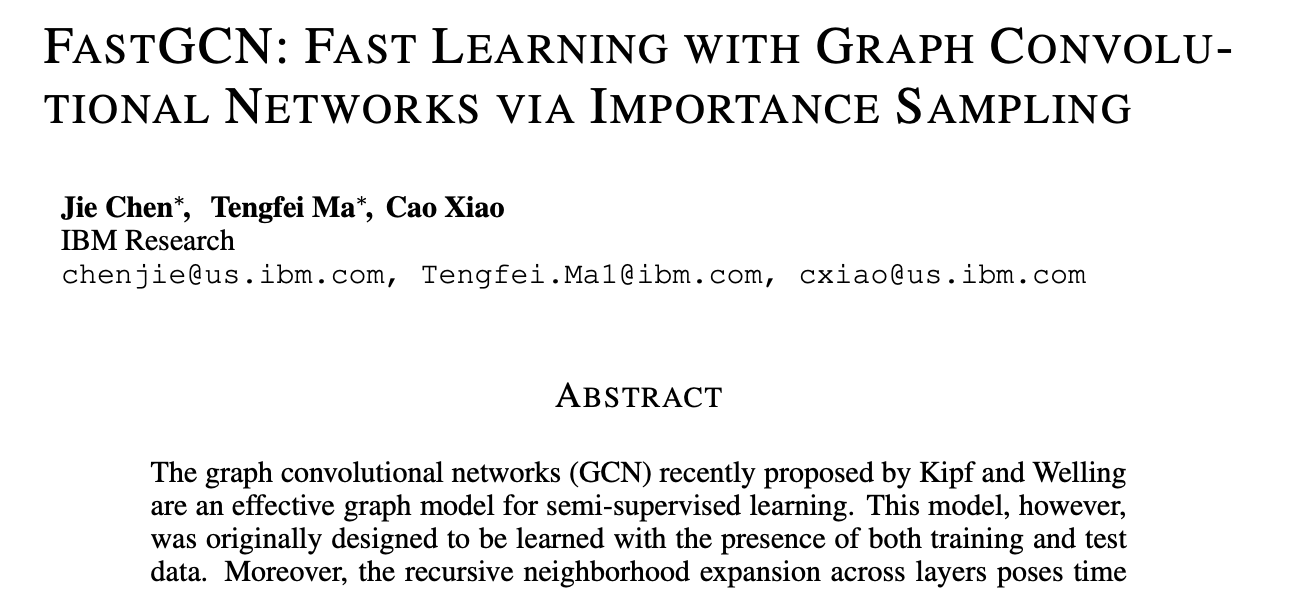

## Notes
- How well documented does code have to be?
- Reddti dataset too big for RAM

-> Check variance of sampled nodes!

## Imports


In [ ]:
!pip install torch-geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid, Reddit
from sklearn.metrics import f1_score
import numpy as np
import os.path as osp

## Configuration & Hyperparameters

In [ ]:
DATASET_CONFIG = {
    'Cora': {
        'hidden_channels': 16,
        'sample_size': 400,
        'batch_size': 256,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'root': '/tmp/Cora'
    },
    'Pubmed': {
        'hidden_channels': 16,
        'sample_size': 100,
        'batch_size': 1024,
        'lr': 0.01,
        'weight_decay': 5e-4,
        'root': '/tmp/Pubmed'
    },
    'Reddit': {
        'hidden_channels': 128,
        'sample_size': 400,
        'batch_size': 256,
        'lr': 0.01,
        'weight_decay': 0,
        'root': '/tmp/Reddit'
    }
}


## Data Loading & Split Logic


In [ ]:
def get_dataset(name):
    cfg = DATASET_CONFIG[name]

    if name == 'Reddit':
        dataset = Reddit(root=cfg['root'])
        data = dataset[0]

        return dataset, data

    else: # Cora or Pubmed
        dataset = Planetoid(root=cfg['root'], name=name)
        data = dataset[0]
        data.train_mask = ~(data.val_mask | data.test_mask)

        return dataset, data

## Model Definition


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.W = nn.Linear(in_channels, out_channels, bias=False)

    def forward(self, x, edge_index, norm):
        """
        Standard GCN aggregation: out = D^-1/2 A D^-1/2 X W
        """
        h = self.W(x)

        row, col = edge_index
        out = torch.zeros((x.size(0), self.W.out_features), device=x.device)

        # normalization
        weighted_h = norm.unsqueeze(1) * h[col]
        out.index_add_(0, row, weighted_h)

        return out

class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNLayer(in_channels, hidden_channels)
        self.conv2 = GCNLayer(hidden_channels, out_channels)

    def forward(self, x, edge_index, norm):
        # Layer 1
        x = self.conv1(x, edge_index, norm)
        x = F.relu(x)
        # Layer 2
        x = self.conv2(x, edge_index, norm)
        return F.log_softmax(x, dim=1)

def compute_gcn_norm(edge_index, num_nodes):
    """
    Computes the symmetric normalization coefficients: 1 / sqrt(d_i * d_j)
    """
    #add self-loops
    loop_index = torch.arange(num_nodes, device=edge_index.device).unsqueeze(0).repeat(2, 1)
    edge_index_sl = torch.cat([edge_index, loop_index], dim=1)

    row, col = edge_index_sl
    deg = torch.bincount(row, minlength=num_nodes).float()

    norm = 1.0 / torch.sqrt(deg[row] * deg[col])

    return edge_index_sl, norm


## Training Run Definition

In [ ]:
import time

def run(dataset_name='Pubmed'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load Data
    dataset, data = get_dataset(dataset_name)
    data = data.to(device)

    edge_index_sl, norm = compute_gcn_norm(data.edge_index, data.num_nodes)

    model = GCNModel(
        in_channels=data.num_features,
        hidden_channels=16,
        out_channels=dataset.num_classes
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data.x, edge_index_sl, norm)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def test():
        model.eval()
        out = model(data.x, edge_index_sl, norm)

        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = out[mask].argmax(dim=1)
            y = data.y[mask]
            accs.append(f1_score(y.cpu(), pred.cpu(), average='micro'))
        return accs

    print(f"Starting training on {device}...")
    epoch_times = []

    for epoch in range(1, 201):
        if device.type == 'cuda': torch.cuda.synchronize()
        start_time = time.time()

        loss = train()

        if device.type == 'cuda': torch.cuda.synchronize()
        epoch_duration = time.time() - start_time
        epoch_times.append(epoch_duration)

        if epoch % 20 == 0:
            tr, va, te = test()
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Time: {epoch_duration:.4f}s | Train: {tr:.4f} | Val: {va:.4f} | Test: {te:.4f}")

    avg_time = sum(epoch_times) / len(epoch_times)
    print(f"\n--- Training Complete ---")
    print(f"Average time per epoch: {avg_time:.4f}s")
    return avg_time

In [ ]:
a1 = run('Pubmed')
a2 = run('Pubmed')
a3 = run('Pubmed')
b1 = run('Cora')
b2 = run('Cora')
b3 = run('Cora')

print(f"Mean_Pubmed: {np.mean([a1, a2, a3])}, Std_Pubmed: {np.std([a1, a2, a3])}")
print(f"Mean_Cora: {np.mean([b1, b2, b3])}, Std_Cora: {np.std([b1, b2, b3])}")

#run('Reddit')

Starting training on cpu...
Epoch 020 | Loss: 0.8800 | Time: 0.0378s | Train: 0.7783 | Val: 0.7720 | Test: 0.7830
Epoch 040 | Loss: 0.5943 | Time: 0.0396s | Train: 0.8313 | Val: 0.8480 | Test: 0.8320
Epoch 060 | Loss: 0.4833 | Time: 0.0596s | Train: 0.8495 | Val: 0.8740 | Test: 0.8590
Epoch 080 | Loss: 0.4401 | Time: 0.0386s | Train: 0.8594 | Val: 0.8920 | Test: 0.8650
Epoch 100 | Loss: 0.4159 | Time: 0.0435s | Train: 0.8642 | Val: 0.8920 | Test: 0.8700
Epoch 120 | Loss: 0.4002 | Time: 0.0402s | Train: 0.8682 | Val: 0.8940 | Test: 0.8760
Epoch 140 | Loss: 0.3891 | Time: 0.0550s | Train: 0.8705 | Val: 0.8920 | Test: 0.8730
Epoch 160 | Loss: 0.3807 | Time: 0.0389s | Train: 0.8723 | Val: 0.8940 | Test: 0.8760
Epoch 180 | Loss: 0.3741 | Time: 0.0394s | Train: 0.8736 | Val: 0.8940 | Test: 0.8760
Epoch 200 | Loss: 0.3687 | Time: 0.0437s | Train: 0.8748 | Val: 0.8920 | Test: 0.8760

--- Training Complete ---
Average time per epoch: 0.0442s
Starting training on cpu...
Epoch 020 | Loss: 0.8887 